In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sys.path.append(os.getcwd() + '/../../')
from matplotlib.patches import Ellipse
from numpy.random import multivariate_normal as m_normal
import plda
from scipy.stats import norm, chi2


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# Define helper plotting functions.

In [2]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """ Code is slightly modified, but essentially borrowed from: 
         https://stackoverflow.com/questions/18764814/make-contour-of-scatter
    """
    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('Either `q` or `nsig` should be specified')

    r2 = chi2.ppf(q, 2)
    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

def plot_scatter(ax, x, y, s=5, c='black', label='', plot_training_cov=False,
                 model=None):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    if plot_training_cov is True:
        assert model is not None
    
    ax.scatter(x, y, c=c, s=s, label=label)

    if plot_training_cov is True:
        cov = model.data[label]['cov']
        mean_x, mean_y = model.data[label]['mean']
        w, h, deg = cov_ellipse(cov, nsig=2)
        ell = Ellipse(xy=(mean_x, mean_y),
                      width=w, height=h,
                      angle=deg, linewidth=2)
        ell.set_facecolor('none')
        ell.set_edgecolor('black')
        ax.add_patch(ell)
    ax.set_aspect('equal')

    return ax

def lbls_to_clrs(lbls, lbl_clr_pairs):
    assert len(np.unique(lbls)) == len(lbl_clr_pairs)
    assert isinstance(lbls, np.ndarray)
    assert isinstance(lbl_clr_pairs, list)
    assert isinstance(lbl_clr_pairs[0], tuple)

    colors = np.empty((*lbls.shape, lbl_clr_pairs[0][1].shape[0]),
                      dtype=lbl_clr_pairs[0][1].dtype)
    for lbl, clr in lbl_clr_pairs:
        colors[lbls == lbl] = clr

    return colors

# Generate an artificial training and test dataset.

In [3]:
def gen_training_set(n_gaussians, sample_size, n_dims):
    cov = np.random.randint(-10, 10, (n_dims, n_dims))
    cov = np.matmul(cov, cov.T) + np.eye(n_dims) * np.random.rand(n_dims)

    pts = np.vstack([m_normal(np.ones(n_dims) * np.random.randint(-100, 100, 1),
                              cov, sample_size) \
                     for x in range(n_gaussians)])
    lbls = np.hstack([['gaussian_{}'.format(x)] * sample_size for x in range(n_gaussians)])

    return pts, lbls

n_gaussians = 5
sample_size = 100
n_dims = 2
n_test = 5000

# Initialize training and test data.
np.random.seed(0)
train_X, train_Y = gen_training_set(n_gaussians, sample_size, n_dims)

margin = np.sqrt(np.cov(train_X.T).diagonal().sum()) * .1
(min_x, min_y), (max_x, max_y) = np.min(train_X, axis=0) - margin,\
                                 np.max(train_X, axis=0) + margin

test = np.asarray([np.random.uniform(min_x, max_x, n_test),
                   np.random.uniform(min_y, max_y, n_test)]).T

In [4]:
train_X.shape
train_Y.shape

train_Y[0:17]

train_X[0:5]

(500, 2)

(500,)

array(['gaussian_0', 'gaussian_0', 'gaussian_0', 'gaussian_0',
       'gaussian_0', 'gaussian_0', 'gaussian_0', 'gaussian_0',
       'gaussian_0', 'gaussian_0', 'gaussian_0', 'gaussian_0',
       'gaussian_0', 'gaussian_0', 'gaussian_0', 'gaussian_0',
       'gaussian_0'], dtype='<U10')

array([[ -74.15164856,  -98.41427575],
       [ -79.0298314 ,  -79.78436645],
       [ -85.74296568,  -62.45021403],
       [ -68.71898127, -109.06401602],
       [ -74.12859075,  -83.71518872]])

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(train_Y)

labels = le.transform(train_Y)


sample_indexes = np.random.choice(500,11)
train_Y[sample_indexes]
labels[sample_indexes]

LabelEncoder()

array(['gaussian_1', 'gaussian_0', 'gaussian_0', 'gaussian_4',
       'gaussian_3', 'gaussian_3', 'gaussian_3', 'gaussian_0',
       'gaussian_1', 'gaussian_1', 'gaussian_4'], dtype='<U10')

array([1, 0, 0, 4, 3, 3, 3, 0, 1, 1, 4])

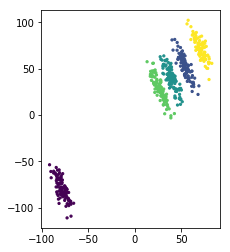

In [6]:
ax = plt.gca()
plot_scatter(ax, train_X[:,0], train_X[:,1], s=5, c=labels, label=labels )

# Create the model and make predictions.

In [7]:
# Create and fit a PLDA classifier to training data.
classifier = plda.Classifier(train_X, train_Y)
classifier.fit_model()

# Classify test data.
predictions, log_probs = classifier.predict(test, standardize_data=True)
# The model makes predictions using the latent space.
# If you have not run classifier.model.whiten() on your data, set standardize_data to True.

In [8]:
N = train_X.shape[0]

Sw = classifier.model.S_w
Sb = classifier.model.S_b

St = Sw + Sb

Sw
Sb

print('========')
St

S = np.cov(train_X[:,0],train_X[:,1])

S
St

(S - St)/S


array([[ 28.99056792, -52.57278515],
       [-52.57278515, 139.66850607]])

array([[2779.868497  , 2788.6271106 ],
       [2788.6271106 , 2798.67230986]])

array([[2808.85906492, 2736.05432545],
       [2736.05432545, 2938.34081593]])

array([[2814.488041  , 2741.53740025],
       [2741.53740025, 2944.22927447]])

array([[2808.85906492, 2736.05432545],
       [2736.05432545, 2938.34081593]])

array([[0.002, 0.002],
       [0.002, 0.002]])

In [9]:
W = classifier.model.calc_W(Sb, Sw)
W

print('Lambdas')
Lambda_t = np.matmul(np.matmul(W.T, St), W)

Lambda_w = classifier.model.calc_Λ_w(Sw, W)
Lambda_b = classifier.model.calc_Λ_b(Sb, W)


## It is true

Lambda_sum = (Lambda_w + Lambda_b)

Lambda_w

Lambda_b

Lambda_t

Lambda_sum

(Lambda_t - Lambda_sum)/Lambda_sum


array([[-0.06057302,  0.32404914],
       [ 0.06037466,  0.13752324]])

Lambdas


array([[ 1.00000000e+00, -2.22044605e-16],
       [-2.77555756e-16,  1.00000000e+00]])

array([[ 4.58932694e-03, -2.04636655e-14],
       [ 1.42108547e-14,  5.93384639e+02]])

array([[ 1.00458933e+00, -2.84217094e-14],
       [ 0.00000000e+00,  5.94384639e+02]])

array([[ 1.00458933e+00, -2.06857101e-14],
       [ 1.39332990e-14,  5.94384639e+02]])

array([[ 3.31545337e-15,  3.73977945e-01],
       [-1.00000000e+00,  0.00000000e+00]])

In [10]:
x_new = np.array([2.0,1.0])

K = n_gaussians

n_avg = N/K

m = np.mean(train_X,axis=0)

A = classifier.model.calc_A(n_avg, Lambda_w, W)
A 

u1 = np.matmul(W.T,x_new)

A_inv = np.linalg.inv(A)

u2 = np.matmul(A_inv,x_new - m)

nu1 = np.linalg.norm(u1)
nu2 = np.linalg.norm(u2)

u1 = u1/nu1
u2 = u2/nu2

(u1 + u2)

np.dot(u1,u2)

np.arccos(np.matmul(u1,u2.T))/np.pi
## u1 n u2 is the oposite direction 


array([[-4.95494747,  2.17529251],
       [11.67545531,  2.18243953]])

array([-0.08113291, -0.00297047])

-0.9967043138264179

0.9741501875109033

In [11]:
Psi = classifier.model.calc_Ψ(Lambda_w, Lambda_b, n_avg)

Psi

print('Phis')
Phi_w = np.matmul(A,A.T)
Phi_b = np.matmul(A,np.matmul(Psi,A.T))
                  
                  
Phi_w2 = n_avg/(n_avg - 1) * Sw


Phi_w
Phi_w2

(Phi_w - Phi_w2)/Phi_w

print('Phi_b')
    
Phi_b2 = Sb - 1.0/(n_avg - 1)*Sw


Phi_b
Phi_b2


array([[  0.        ,   0.        ],
       [  0.        , 587.44079228]])

Phis


array([[ 29.28340194, -53.10382339],
       [-53.10382339, 141.07929906]])

array([[ 29.28340194, -53.10382339],
       [-53.10382339, 141.07929906]])

array([[2.42643507e-16, 2.67605114e-16],
       [2.67605114e-16, 2.01459106e-16]])

Phi_b


array([[2779.70962989, 2788.84247955],
       [2788.84247955, 2798.00533556]])

array([[2779.57566298, 2789.15814883],
       [2789.15814883, 2797.26151687]])

In [12]:
for prediction, test_point in zip(predictions[::500], test[::500]):
    print(prediction, test_point)

gaussian_4 [68.75774632 86.97997687]
gaussian_2 [  6.9247109  102.82273503]
gaussian_1 [73.77207899 26.31019444]
gaussian_0 [-29.50344444 -99.68188444]
gaussian_3 [-38.43325157   8.04683982]
gaussian_0 [-90.42348804  53.62491286]
gaussian_3 [-39.61493921  53.64834459]
gaussian_2 [ 62.88891438 -26.90913668]
gaussian_0 [-66.92579428 -95.44303968]
gaussian_3 [  2.94054124 -40.80783134]


In [13]:
# Predictions, and log posterior predictive probabilitites for each category.
print('Prediction', list(classifier.model.data.keys()))
for prediction, logps in zip(predictions[::500], log_probs[::500]):
    print(prediction, logps.round(2))

Prediction ['gaussian_0', 'gaussian_1', 'gaussian_2', 'gaussian_3', 'gaussian_4']
gaussian_4 [-2.4462e+03 -4.4720e+01 -1.2635e+02 -2.3160e+02 -1.8700e+00]
gaussian_2 [-1366.06   -35.54    -2.62    -8.14  -133.82]
gaussian_1 [-2003.15    -4.59   -43.12  -110.85   -14.83]
gaussian_0 [  -85.33 -1132.85  -845.58  -629.65 -1544.49]
gaussian_3 [-308.34 -640.92 -430.12 -280.76 -958.35]
gaussian_0 [ -103.48 -1070.51  -791.84  -583.41 -1471.54]
gaussian_3 [-469.89 -449.35 -276.31 -159.84 -720.24]
gaussian_2 [-1381.31   -33.16    -2.13    -9.29  -129.11]
gaussian_0 [-2.15000e+00 -1.74195e+03 -1.38063e+03 -1.10023e+03 -2.24481e+03]
gaussian_3 [-494.46 -425.94 -258.03 -146.03 -690.51]


# Visualize predictions.

(-99.42489615154012, 90.74439561410676)

(-118.52662295633907, 109.79828379018653)

Text(0.5,0,'Dimension 1')

Text(0,0.5,'Dimension 2')

Text(0.5,1,'Demo')

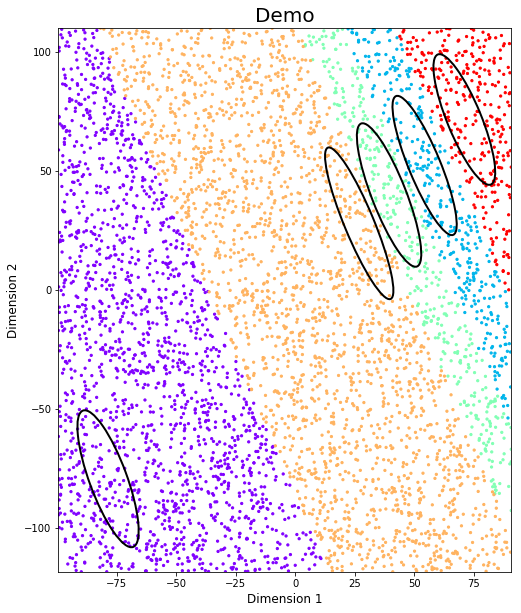

In [14]:
# Plot classified data.
colors = cm.rainbow(np.linspace(0, 1, n_gaussians))
unique = np.unique(predictions)
c = lbls_to_clrs(predictions, [pair for pair in zip(unique, colors)])

fig, ax_arr = plt.subplots(1)
for label in unique:
    idxs = predictions == label
    plot_scatter(ax_arr, test[idxs, 0], test[idxs, 1],
                 label=label, c=c[idxs, :], plot_training_cov=True,
                 model=classifier.model)

(min_x, min_y), (max_x, max_y) = np.min(test, axis=0), np.max(test, axis=0)
ax_arr.set_xlim(min_x, max_x)
ax_arr.set_ylim(min_y, max_y)
fig.set_size_inches(10, 10)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Demo', fontsize=20)

plt.show()

# Unique categories.

In [17]:
classifier.model.data['gaussian_0'].keys()

dict_keys(['X', 'fnames', 'mean', 'cov', 'n'])

# Accessing Model Parameters

In [18]:
classifier.model.Ψ  # Prior covariance in latent space.

array([[  0.        ,   0.        ],
       [  0.        , 587.44079228]])

In [19]:
classifier.model.A  # Used to transform the data to latent spae.

array([[-4.95494747,  2.17529251],
       [11.67545531,  2.18243953]])

In [20]:
classifier.model.m  # Mean of the training dataset.

array([22.63658095, 22.34330327])

In [21]:
# Category means in data space and latent space.
means, labels = classifier.model.get_means(return_labels=True)
latent_means = classifier.model.whiten(np.asarray(means))

for label, mean, latent_mean in zip(labels, means, latent_means):
    print(label, mean, latent_mean)

gaussian_0 [-78.5915944  -79.44826685] [-1.38649525e-02 -4.65670133e+01]
gaussian_1 [54.37257535 52.13593703] [-0.12300532 14.30911442]
gaussian_2 [39.44208438 39.73197171] [0.03171502 7.79787066]
gaussian_3 [26.90439342 27.84556694] [0.07331365 2.12894484]
gaussian_4 [71.05544599 71.45130751] [ 0.0318416  22.33108338]


# Transforming data to latent space.

In [22]:
U = classifier.model.whiten(test)

print('Latent space\t\t\t', 'Data space')
for u, x in zip(U[::500], test[::500]):
    print('{}\t{}'.format(u, x))

Latent space			 Data space
[ 1.10316126 23.71509631]	[68.75774632 86.97997687]
[5.78150776 5.94641736]	[  6.9247109  102.82273503]
[-2.84360651 17.03015889]	[73.77207899 26.31019444]
[ -4.1878527  -33.50842016]	[-29.50344444 -99.68188444]
[  2.8218245  -21.64667051]	[-38.43325157   8.04683982]
[  8.69321214 -32.17298779]	[-90.42348804  53.62491286]
[  5.63241905 -15.78784436]	[-39.61493921  53.64834459]
[-5.38467795  6.23894807]	[ 62.88891438 -26.90913668]
[ -1.67779418 -44.9942969 ]	[-66.92579428 -95.44303968]
[ -2.60654835 -14.99170785]	[  2.94054124 -40.80783134]


(5000, 2)

(5000, 2)

(5000,)

(-13.404243696196541,
 13.743595162879162,
 -61.418481794896636,
 37.30536776573632)

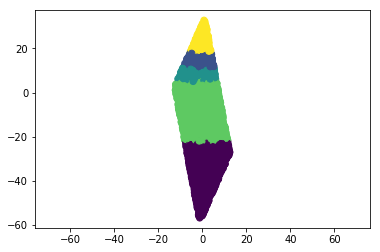

In [32]:
U.shape
test.shape
predictions.shape

# test data is uniform data

y_test = le.transform(predictions)
#y_test = predictions

ax = plt.gca()
ax.scatter(U[:, 0], U[:, 1], c=y_test, s=40, cmap='viridis', zorder=2)
#ax.scatter(V[:, 0], V[:, 1], c='red', s=40, cmap='viridis', zorder=2)
#ax.scatter(0, 0, c='black', s=40, cmap='viridis', zorder=2)
ax.axis('equal')